# from .out file to a plot of mutation directions

put full path to single_locus_trajectories.out file, full path to reference .dat file, desired coverage cutoff, and desired minimum variant frequency below

In [5]:
variant_path = "/Users/e.smith.5/Documents/PhD/RSV_project/RSV_haplotype_reconstruction/data/Single_locus_trajectories05.out"

ref_dat_path = "/Users/e.smith.5/Documents/PhD/RSV_project/RSV_haplotype_reconstruction/data/ref/Reading_Frames.dat"

coverage_threshold = 0

minimum_frequency = 0.1

0.1

In [6]:
# read variants file into a dataframe
using DataFrames

# Define the function to read the .out file
function read_out_file(filepath::String)
    # Initialize an empty DataFrame
    df = DataFrame(pos = Int[], original_base = String[], variant_base = String[])
    
    # Open the file and process each line
    open(filepath, "r") do file
        for line in eachline(file)
            # Remove any leading/trailing whitespace
            stripped_line = strip(line)
            
            # Continue only if the line is not empty
            if !isempty(stripped_line)
                # Split the line into parts, typically space-delimited
                parts = split(stripped_line)
                
                # Ensure there are enough parts to avoid index errors
                if length(parts) < 3
                    continue  # Skip this line if it doesn't have enough parts
                end

                # Extract the position, original base, and variant base
                pos = parse(Int, parts[1])
                original_base = parts[2]  # Should be a single character string
                variant_base = parts[3]   # Should be a single character string
                
                # Append to the DataFrame
                push!(df, (pos, original_base, variant_base))
            end
        end
    end
    
    return df
end

variants = read_out_file(variant_path)

Row,pos,original_base,variant_base
,Int64,String,String
1,11,A,G
2,18,A,G
3,141,G,A
4,144,G,T
5,202,C,T
6,380,T,C
7,561,C,T
8,574,T,C
9,576,G,A


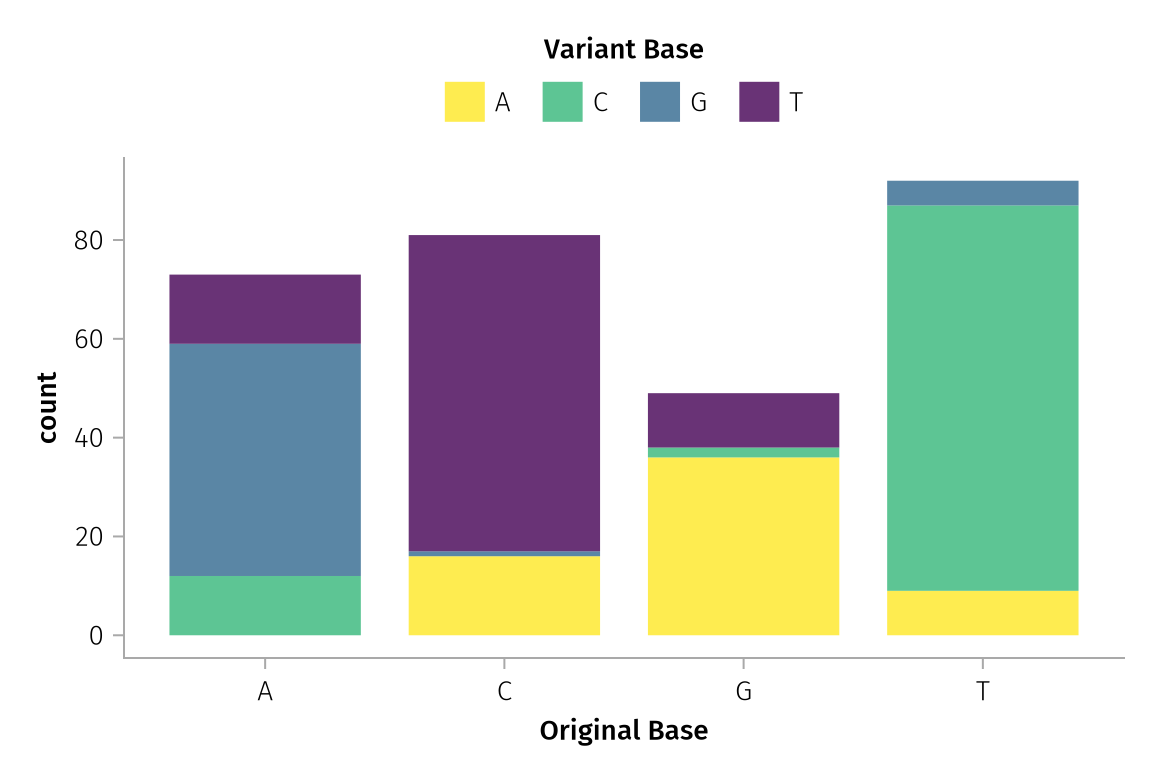

In [7]:
# try using AoG for plotting inside Julia
using AlgebraOfGraphics, CairoMakie
using Colors
set_aog_theme!()

axis = (width = 500, height = 250, xlabel = "Original Base")

mutation_frequency = data(variants) * frequency() * mapping(:original_base, color = :variant_base => "Variant Base", stack = :variant_base)
colors = ["A" => colorant"#FDE725CC", "C" => colorant"#35B779CC", "G" => colorant"#31688ECC", "T" => colorant"#440154CC"]
draw(mutation_frequency; palettes=(color=colors,), axis = axis, legend=(position=:top, titleposition=:top))

In [8]:
# pull two .fas from .dat file 
using RCall

# Function to handle the .dat file processing
function pull_frames(dat_file_path::String)
    # Define and call the R processing function within RCall
    @rput dat_file_path  # This passes the Julia variable to R
    R"""
    library(Biostrings)

    process_file <- function(file_path) {
        lines <- tryCatch({
            readLines(file_path)
        }, error = function(e) {
            cat("Error reading file:", e$message, "\n")
            return(NULL)  # Return NULL to handle error gracefully
        })
        if (is.null(lines)) return()  # Exit if file could not be read

        fasta_nucleotide_path <- sub(".dat$", "_nucleotide.fa", file_path)
        fasta_amino_acid_path <- sub(".dat$", "_amino_acid.fa", file_path)
        
        con_nuc <- file(fasta_nucleotide_path, open = "w")
        con_aa <- file(fasta_amino_acid_path, open = "w")
        
        for (i in seq(1, length(lines), by = 3)) {
            if (i + 2 > length(lines)) {
                break
            }
            header <- strsplit(lines[i], " ")[[1]]
            if (length(header) < 3) {
                next
            }
            start_pos <- header[1]
            end_pos <- header[2]
            annotation <- paste(header[3:length(header)], collapse=" ")
            full_annotation <- paste0('"accession":', start_pos, '..', end_pos, ' | ', annotation)
            dna_seq <- DNAString(lines[i+1])
            aa_seq <- AAString(lines[i+2])
            
            writeLines(paste0(">", full_annotation), con_nuc)
            writeLines(as.character(dna_seq), con_nuc)
            writeLines(paste0(">", full_annotation), con_aa)
            writeLines(as.character(aa_seq), con_aa)
        }
        
        close(con_nuc)
        close(con_aa)
    }
    """
    # Call the R function from Julia
    R"process_file($(dat_file_path))"
    
    # Julia takes over after the R function to print the paths
    fasta_nucleotide_path = replace(dat_file_path, ".dat" => "_nucleotide.fa")
    fasta_amino_acid_path = replace(dat_file_path, ".dat" => "_amino_acid.fa")
    
    println("nucleotide .fa : ", fasta_nucleotide_path)
    println("amino acid .fa : ", fasta_amino_acid_path)
end



pull_frames(ref_dat_path)

nucleotide .fa : /Users/e.smith.5/Documents/PhD/RSV_project/RSV_haplotype_reconstruction/data/ref/Reading_Frames_nucleotide.fa
amino acid .fa : /Users/e.smith.5/Documents/PhD/RSV_project/RSV_haplotype_reconstruction/data/ref/Reading_Frames_amino_acid.fa
